In [1]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [2]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings
from scipy.stats import ks_2samp

warnings.filterwarnings("ignore")

# %matplotlib inline
# mpld3.enable_notebook()

In [4]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [5]:
# ------ Get cfpdss data with missing values
df_cfpdss_missing = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss_m0.5.csv"
)
df_cfpdss_missing = df_cfpdss_missing.iloc[:, 1:]
df_cfpdss_missing.iloc[49:55]

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
49,a,a,a,a,a,-0.192318,0.714631,1.188953,2.146077,1.393357,0
50,NaN,a,a,NaN,NaN,0.178767,NaN,NaN,NaN,0.269626,0
51,NaN,a,a,a,NaN,1.364684,-0.428681,NaN,1.122679,NaN,0
52,NaN,b,b,NaN,NaN,-0.878532,2.046157,4.402366,-0.633157,0.579233,0
53,NaN,NaN,NaN,a,a,0.794489,-1.089565,NaN,0.096427,NaN,1
54,NaN,NaN,a,a,NaN,NaN,NaN,NaN,0.282534,NaN,0


In [6]:
def data_encoding(data, feature_scaling=True):
    X_df = data.drop(columns="class")

    # Separating categorical and non-categorical columns
    categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
    X_df_categorical = X_df[categorical_columns]
    non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
    X_df_non_categorical = X_df[non_cat_columns]

    # Record the indices of missing values for each categorical feature
    missing_indices = {
        col: X_df_categorical[col].index[X_df_categorical[col].isna()].tolist()
        for col in categorical_columns
    }

    # Impute NaN values in categorical features with the most frequent value from the same column
    X_df_categorical = X_df_categorical.apply(
        lambda col: col.fillna(
            col.mode()[0] if not col.mode().empty else col.value_counts().index[0]
        )
    )

    # One hot encoding - Categorical data
    encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    one_hot_encoded = encoder.fit_transform(X_df_categorical)
    columns = encoder.get_feature_names_out(categorical_columns)
    X_df_cat_one_hot = pd.DataFrame(
        one_hot_encoded, columns=columns, index=X_df_categorical.index
    )

    # Replace the imputed values back with NaNs in the encoded DataFrame
    for col, indices in missing_indices.items():
        for index in indices:
            cols_to_check = [c for c in X_df_cat_one_hot.columns if c.startswith(col)]
            for c in cols_to_check:
                X_df_cat_one_hot.at[index, c] = np.nan

    # Feature scaling numerical data/non-categorical data
    if feature_scaling:
        scaler = MinMaxScaler()
        X_df_non_categorical = pd.DataFrame(
            scaler.fit_transform(X_df_non_categorical),
            columns=X_df_non_categorical.columns,
            index=X_df_non_categorical.index,
        )

    # Concatenate categorical and non-categorical data
    X_df_encoded = pd.concat(
        [
            X_df_cat_one_hot,
            X_df_non_categorical,
            # X_df_categorical  # Re-add the original categorical columns with NaNs
        ],
        axis=1,
    )

    # Encoding the target variable
    y_df = data[["class"]]
    y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    y_one_hot = y_encoder.fit_transform(y_df)
    y_encoded = pd.Series(y_one_hot.ravel())

    return X_df_encoded, y_encoded

In [7]:
# ------ Encode missing and non-missing ddata
X_df_encoded, y_encoded = data_encoding(df_cfpdss)
X_df_encoded_m, y_encoded_m = data_encoding(df_cfpdss_missing)

In [8]:
X_df_encoded_m.isna().sum()

c5_b    6545
c6_b    6418
c7_b    6433
c8_b    6485
c9_b    6632
n0      6514
n1      6495
n2      6474
n3      6488
n4      6541
dtype: int64

In [9]:
X_df_encoded_m.head()

,c5_b,c6_b,c7_b,c8_b,c9_b,n0,n1,n2,n3,n4
0,0.0,0.0,1.0,0.0,0.0,0.530356,0.598345,0.519161,0.478557,0.620371
1,0.0,0.0,0.0,1.0,1.0,0.672618,0.423329,0.442055,0.449888,0.458838
2,0.0,0.0,0.0,1.0,1.0,0.567192,0.576429,0.505532,0.364614,0.550814
3,0.0,0.0,0.0,1.0,1.0,0.474236,0.566046,0.499081,0.416457,0.552283
4,1.0,0.0,0.0,1.0,0.0,0.363202,0.554642,0.495610,0.216550,0.397683


In [10]:
X_df_encoded_m_cat = X_df_encoded_m.filter(regex="^c")
X_df_encoded_m_cat.head()

,c5_b,c6_b,c7_b,c8_b,c9_b
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,1.0,0.0


In [11]:
grouped = X_df_encoded_m_cat.groupby(X_df_encoded_m_cat.index // 10)

# Apply an aggregation function, for example, sum
grouped_sum = grouped.sum()

# Display the result
grouped_sum.head()

,c5_b,c6_b,c7_b,c8_b,c9_b
0,4.0,3.0,4.0,7.0,5.0
1,6.0,5.0,5.0,5.0,7.0
2,3.0,3.0,3.0,5.0,5.0
3,7.0,3.0,4.0,5.0,6.0
4,6.0,5.0,4.0,3.0,3.0


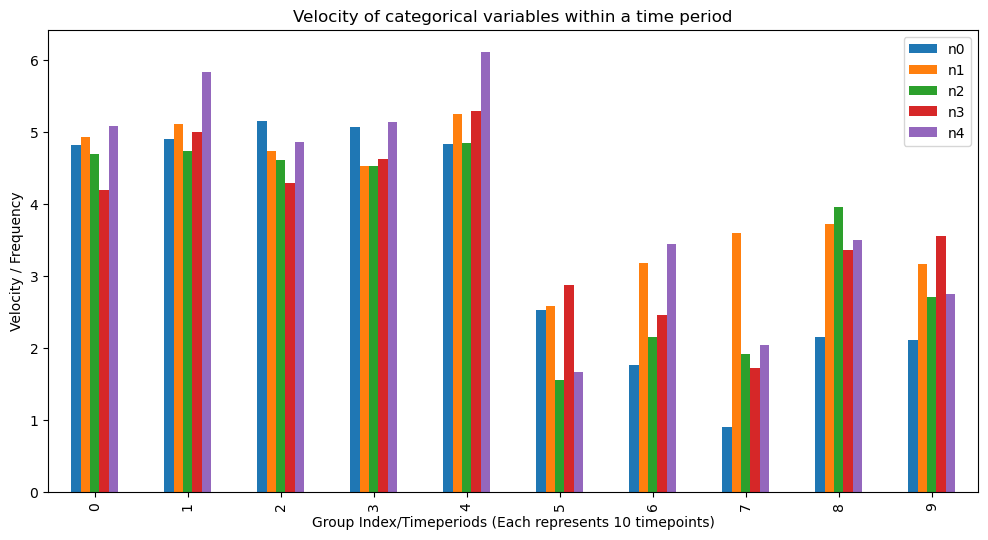

In [25]:
# Plot the result as a bar chart
grouped_sum.iloc[0:10].plot(kind="bar", figsize=(12, 6))

# Add titles and labels
plt.title("Velocity of categorical variables within a time period")
plt.xlabel("Group Index/Timeperiods (Each represents 10 timepoints)")
plt.ylabel("Velocity / Frequency")

# Show the plot
plt.show()
# moving bar, one bar on another

In [13]:
grouped_sum.head()

,c5_b,c6_b,c7_b,c8_b,c9_b
0,4.0,3.0,4.0,7.0,5.0
1,6.0,5.0,5.0,5.0,7.0
2,3.0,3.0,3.0,5.0,5.0
3,7.0,3.0,4.0,5.0,6.0
4,6.0,5.0,4.0,3.0,3.0


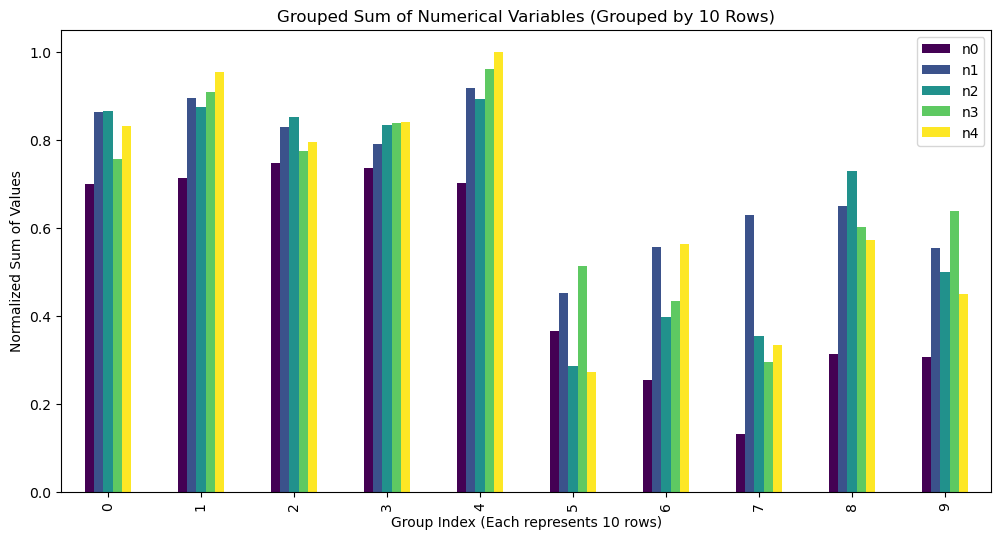

In [14]:
# Filter out numerical columns (you can adjust this condition as needed)
X_df_encoded_m_num = X_df_encoded_m.filter(regex="^n")

# Create a grouping key based on row indices divided by 10
grouped = X_df_encoded_m_num.groupby(X_df_encoded_m_num.index // 10)

# Apply an aggregation function, for example, sum
grouped_sum = grouped.sum()

# Normalize the data so that variables with different ranges can be compared
normalized_grouped_sum = grouped_sum.apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
)

# Plot the result as a bar chart
normalized_grouped_sum.iloc[:10].plot(kind="bar", figsize=(12, 6), colormap="viridis")

# Add titles and labels
plt.title("Grouped Sum of Numerical Variables (Grouped by 10 Rows)")
plt.xlabel("Group Index (Each represents 10 rows)")
plt.ylabel("Normalized Sum of Values")

# Show the plot
plt.show()

In [15]:
# Select the two numerical features
features = ["n0", "n1"]
X_df_encoded_m_num = X_df_encoded_m[features]

# Create a grouping key based on row indices divided by 10
X_df_encoded_m_num["Group"] = X_df_encoded_m_num.index // 10
X_df_encoded_m_num.head()

,n0,n1,Group
0,0.530356,0.598345,0
1,0.672618,0.423329,0
2,0.567192,0.576429,0
3,0.474236,0.566046,0
4,0.363202,0.554642,0


In [16]:
X_df_encoded_m_num.head()

,n0,n1,Group
0,0.530356,0.598345,0
1,0.672618,0.423329,0
2,0.567192,0.576429,0
3,0.474236,0.566046,0
4,0.363202,0.554642,0


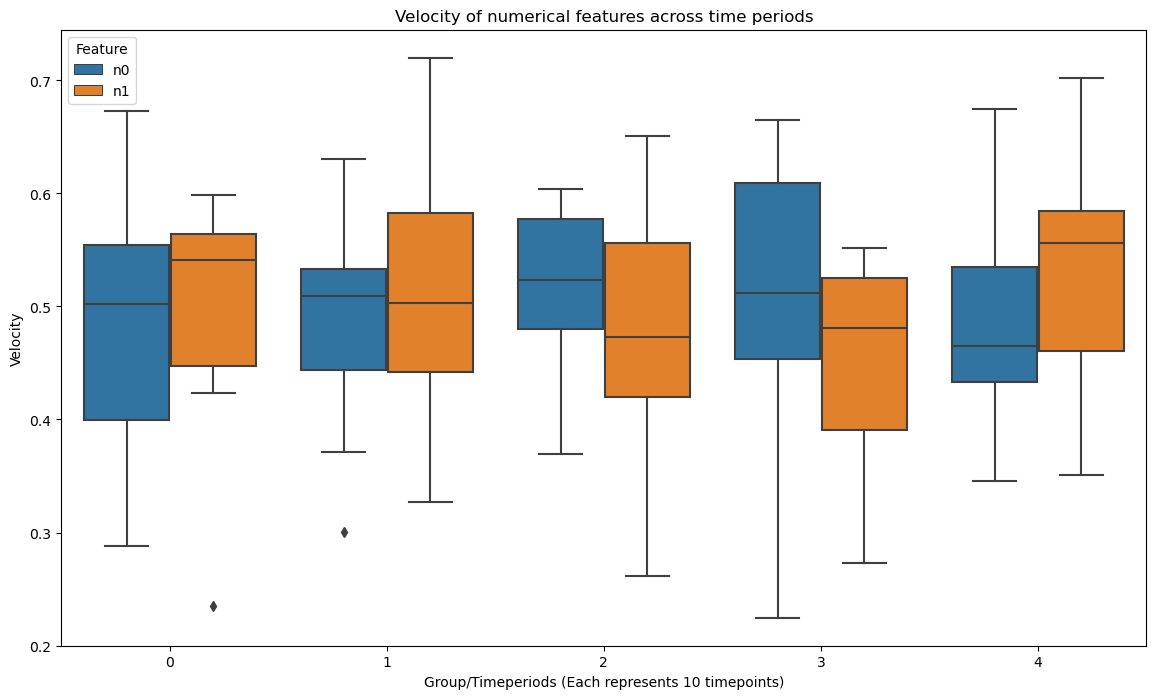

In [24]:
# Select the two numerical features
features = ["n0", "n1"]
X_df_encoded_m_num = X_df_encoded_m[features]

# Create a grouping key based on row indices divided by 10
X_df_encoded_m_num["Group"] = X_df_encoded_m_num.index // 10

# Melt the DataFrame to a long format
melted_df = pd.melt(
    X_df_encoded_m_num,
    id_vars="Group",
    value_vars=features,
    var_name="Feature",
    value_name="Value",
)

melted_df_first_40 = melted_df[melted_df["Group"] < 5]

# Plotting the distributions using box plots
plt.figure(figsize=(14, 8))

sns.boxplot(x="Group", y="Value", hue="Feature", data=melted_df_first_40)
plt.title("Velocity of numerical features across time periods")
plt.xlabel("Group/Timeperiods (Each represents 10 timepoints)")
plt.ylabel("Velocity")
plt.legend(title="Feature")

# Show the plot
plt.show()

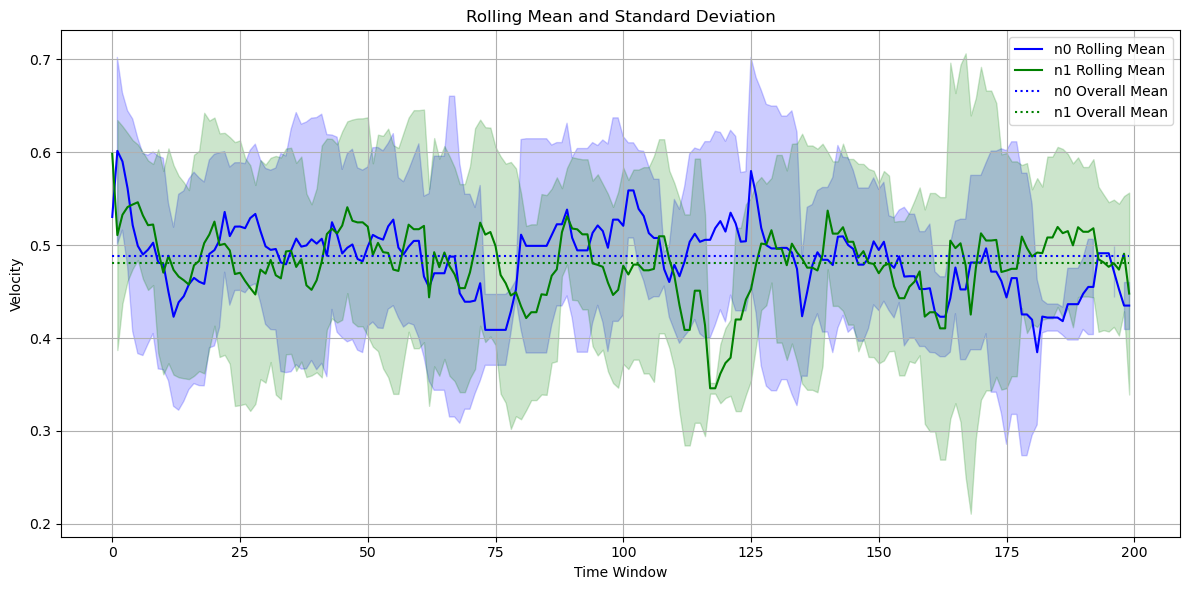

In [21]:
# Select the two numerical features and the first 2000 rows
features = ["n0", "n1"]
X_df_encoded_m_num = X_df_encoded_m[features].iloc[:200]
overall_mean = X_df_encoded_m_num.mean()

# Calculate rolling mean and standard deviation with a window size of 10
window_size = 10
rolling_mean = X_df_encoded_m_num.rolling(window=window_size, min_periods=1).mean()
rolling_std = X_df_encoded_m_num.rolling(window=window_size, min_periods=1).std()

# Combine the results into a single DataFrame
rolling_stats = pd.concat([rolling_mean, rolling_std], axis=1)
rolling_stats.columns = [f"{col}_mean" for col in X_df_encoded_m_num.columns] + [
    f"{col}_std" for col in X_df_encoded_m_num.columns
]

# Plotting the rolling mean and standard deviation
plt.figure(figsize=(12, 6))

# Plot rolling mean for n0
plt.plot(
    rolling_stats.index, rolling_stats["n0_mean"], label="n0 Rolling Mean", color="blue"
)
# Plot standard deviation for n0 (scaled for visibility)
plt.fill_between(
    rolling_stats.index,
    rolling_stats["n0_mean"] - rolling_stats["n0_std"],
    rolling_stats["n0_mean"] + rolling_stats["n0_std"],
    color="blue",
    alpha=0.2,
)

# Plot rolling mean for n1
plt.plot(
    rolling_stats.index,
    rolling_stats["n1_mean"],
    label="n1 Rolling Mean",
    color="green",
)
# Plot standard deviation for n1 (scaled for visibility)
plt.fill_between(
    rolling_stats.index,
    rolling_stats["n1_mean"] - rolling_stats["n1_std"],
    rolling_stats["n1_mean"] + rolling_stats["n1_std"],
    color="green",
    alpha=0.2,
)

# Plot overall mean lines
plt.hlines(
    overall_mean["n0"],
    rolling_stats.index[0],
    rolling_stats.index[-1],
    colors="blue",
    linestyles="dotted",
    label="n0 Overall Mean",
)
plt.hlines(
    overall_mean["n1"],
    rolling_stats.index[0],
    rolling_stats.index[-1],
    colors="green",
    linestyles="dotted",
    label="n1 Overall Mean",
)

plt.title("Rolling Mean and Standard Deviation")
plt.xlabel("Time Window")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

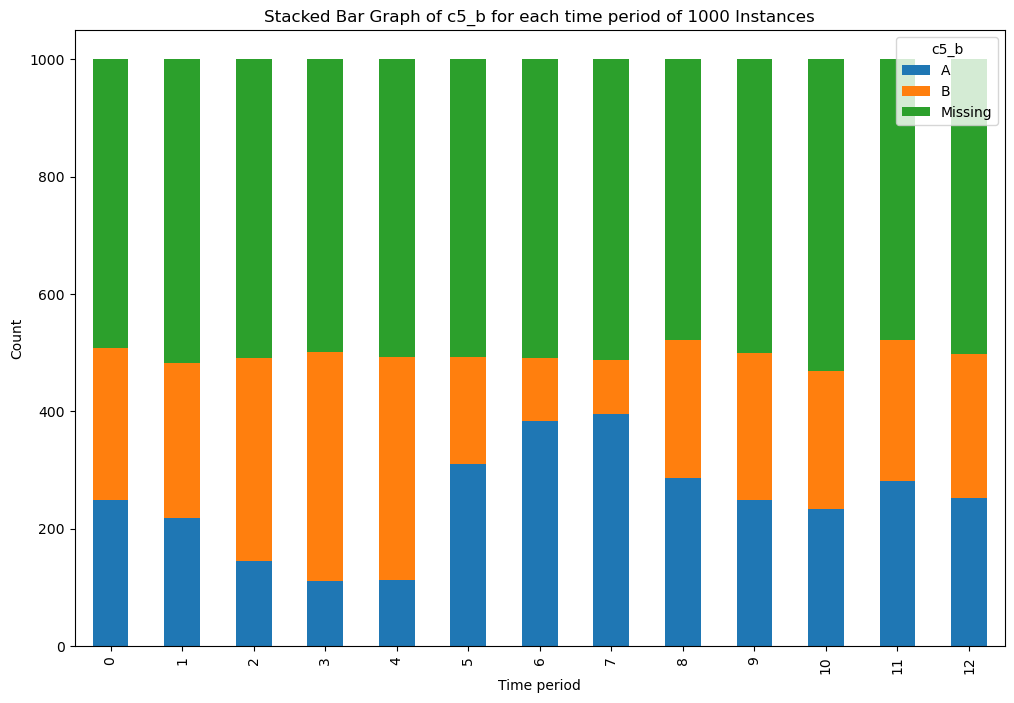

In [28]:
def plot_stacked_bar_graph(df, column, chunk_size):
    num_chunks = len(df) // chunk_size
    chunk_ranges = [(i * chunk_size, (i + 1) * chunk_size) for i in range(num_chunks)]

    counts = []
    for start, end in chunk_ranges:
        chunk = df[start:end]
        count_0 = chunk[column].value_counts().get(0, 0)
        count_1 = chunk[column].value_counts().get(1, 0)
        count_nan = chunk[column].isna().sum()
        counts.append([count_0, count_1, count_nan])

    counts_df = pd.DataFrame(
        counts, columns=["A", "B", "Missing"], index=range(num_chunks)
    )

    counts_df.plot(kind="bar", stacked=True, figsize=(12, 8))
    plt.xlabel("Time period")
    plt.ylabel("Count")
    plt.title(
        f"Stacked Bar Graph of {column} for each time period of {chunk_size} Instances"
    )
    plt.legend(title=column, loc="upper right")
    plt.show()


# Plotting the graph for the sample data
plot_stacked_bar_graph(X_df_encoded_m, "c5_b", 1000)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (130,) and arg 1 with shape (5,).

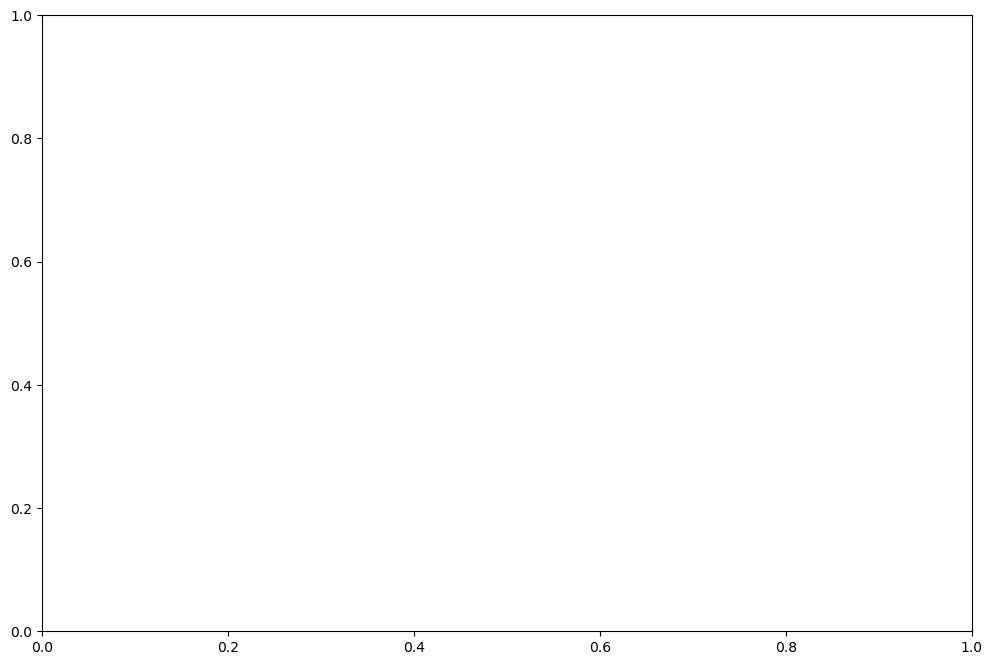

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def plot_grouped_stacked_bar_graph(
    df, column1, column2, chunk_size, start_tp=5, end_tp=10
):
    num_chunks = len(df) // chunk_size
    chunk_ranges = [(i * chunk_size, (i + 1) * chunk_size) for i in range(num_chunks)]

    counts1 = []
    counts2 = []
    for start, end in chunk_ranges:
        chunk = df[start:end]

        count1_0 = chunk[column1].value_counts().get(0, 0)
        count1_1 = chunk[column1].value_counts().get(1, 0)
        count1_nan = chunk[column1].isna().sum()
        counts1.append([count1_0, count1_1, count1_nan])

        count2_0 = chunk[column2].value_counts().get(0, 0)
        count2_1 = chunk[column2].value_counts().get(1, 0)
        count2_nan = chunk[column2].isna().sum()
        counts2.append([count2_0, count2_1, count2_nan])

    counts_df1 = pd.DataFrame(
        counts1, columns=["0", "1", "Missing"], index=range(num_chunks)
    )
    counts_df2 = pd.DataFrame(
        counts2, columns=["0", "1", "Missing"], index=range(num_chunks)
    )
    counts_df1 = counts_df1.iloc[5:10]
    counts_df2 = counts_df1.iloc[5:10]
    ind = np.arange(num_chunks)  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot for column1
    bar1_0 = ax.bar(
        ind - width / 2,
        counts_df1["0"],
        width,
        label=f"{column1} 0",
        color="blue",
        edgecolor="black",
    )
    bar1_1 = ax.bar(
        ind - width / 2,
        counts_df1["1"],
        width,
        bottom=counts_df1["0"],
        label=f"{column1} 1",
        color="orange",
        edgecolor="black",
    )
    bar1_nan = ax.bar(
        ind - width / 2,
        counts_df1["Missing"],
        width,
        bottom=counts_df1["0"] + counts_df1["1"],
        label=f"{column1} Missing",
        color="green",
        edgecolor="black",
    )

    # Plot for column2
    bar2_0 = ax.bar(
        ind + width / 2,
        counts_df2["0"],
        width,
        label=f"{column2} 0",
        color="blue",
        hatch="//",
        edgecolor="black",
    )
    bar2_1 = ax.bar(
        ind + width / 2,
        counts_df2["1"],
        width,
        bottom=counts_df2["0"],
        label=f"{column2} 1",
        color="orange",
        hatch="//",
        edgecolor="black",
    )
    bar2_nan = ax.bar(
        ind + width / 2,
        counts_df2["Missing"],
        width,
        bottom=counts_df2["0"] + counts_df2["1"],
        label=f"{column2} Missing",
        color="green",
        hatch="//",
        edgecolor="black",
    )

    ax.set_xlabel("Time period")
    ax.set_ylabel("Velocity")
    ax.set_title(
        f"Stacked Bar Graph of {column1} and {column2} for each time period of {chunk_size} Instances"
    )
    ax.set_xticks(ind)
    ax.set_xticklabels(range(num_chunks))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()


# Example usage with sample data
plot_grouped_stacked_bar_graph(
    X_df_encoded_m, "c5_b", "c6_b", 100, start_tp=5, end_tp=10
)

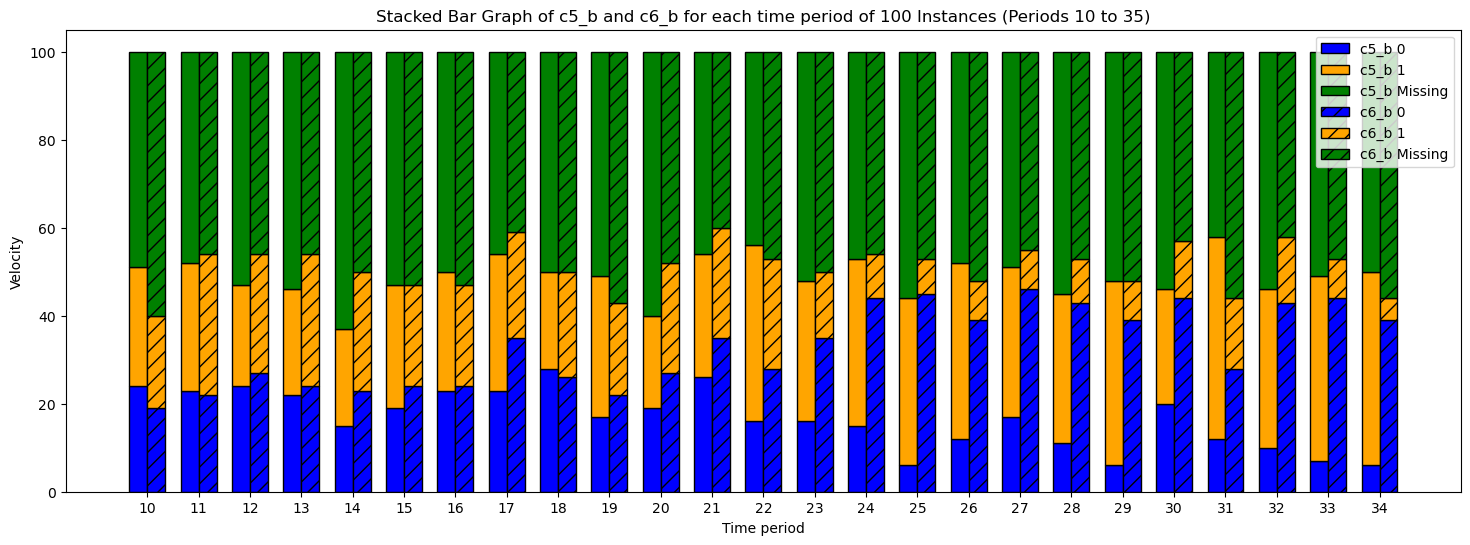

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def plot_grouped_stacked_bar_graph(
    df, column1, column2, chunk_size, start_period, end_period
):
    # Calculate the number of chunks
    num_chunks = len(df) // chunk_size + (1 if len(df) % chunk_size != 0 else 0)

    # Create a column for the chunk number
    df["chunk"] = (df.index // chunk_size).astype(int)

    # Group by the chunk and calculate the counts for each value
    counts_df1 = (
        df.groupby("chunk")[column1]
        .value_counts()
        .unstack(fill_value=0)
        .rename(columns={0: f"{column1}_0", 1: f"{column1}_1"})
    )
    counts_df1[f"{column1}_Missing"] = df.groupby("chunk")[column1].apply(
        lambda x: x.isna().sum()
    )

    counts_df2 = (
        df.groupby("chunk")[column2]
        .value_counts()
        .unstack(fill_value=0)
        .rename(columns={0: f"{column2}_0", 1: f"{column2}_1"})
    )
    counts_df2[f"{column2}_Missing"] = df.groupby("chunk")[column2].apply(
        lambda x: x.isna().sum()
    )

    # Merge the two dataframes on the chunk index
    combined_df = pd.concat([counts_df1, counts_df2], axis=1).fillna(0)

    # Filter the combined_df to include only the specified range
    combined_df = combined_df.iloc[start_period:end_period]

    ind = np.arange(start_period, end_period)  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(18, 6))

    # Plot for column1
    bar1_0 = ax.bar(
        ind - width / 2,
        combined_df[f"{column1}_0"],
        width,
        label=f"{column1} 0",
        color="blue",
        edgecolor="black",
    )
    bar1_1 = ax.bar(
        ind - width / 2,
        combined_df[f"{column1}_1"],
        width,
        bottom=combined_df[f"{column1}_0"],
        label=f"{column1} 1",
        color="orange",
        edgecolor="black",
    )
    bar1_nan = ax.bar(
        ind - width / 2,
        combined_df[f"{column1}_Missing"],
        width,
        bottom=combined_df[f"{column1}_0"] + combined_df[f"{column1}_1"],
        label=f"{column1} Missing",
        color="green",
        edgecolor="black",
    )

    # Plot for column2
    bar2_0 = ax.bar(
        ind + width / 2,
        combined_df[f"{column2}_0"],
        width,
        label=f"{column2} 0",
        color="blue",
        hatch="//",
        edgecolor="black",
    )
    bar2_1 = ax.bar(
        ind + width / 2,
        combined_df[f"{column2}_1"],
        width,
        bottom=combined_df[f"{column2}_0"],
        label=f"{column2} 1",
        color="orange",
        hatch="//",
        edgecolor="black",
    )
    bar2_nan = ax.bar(
        ind + width / 2,
        combined_df[f"{column2}_Missing"],
        width,
        bottom=combined_df[f"{column2}_0"] + combined_df[f"{column2}_1"],
        label=f"{column2} Missing",
        color="green",
        hatch="//",
        edgecolor="black",
    )

    ax.set_xlabel("Time period")
    ax.set_ylabel("Velocity")
    ax.set_title(
        f"Stacked Bar Graph of {column1} and {column2} for each time period of {chunk_size} Instances (Periods {start_period} to {end_period})"
    )
    ax.set_xticks(ind)
    ax.set_xticklabels(range(start_period, end_period))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()


# Example usage with sample data
plot_grouped_stacked_bar_graph(X_df_encoded_m, "c5_b", "c6_b", 100, 10, 35)

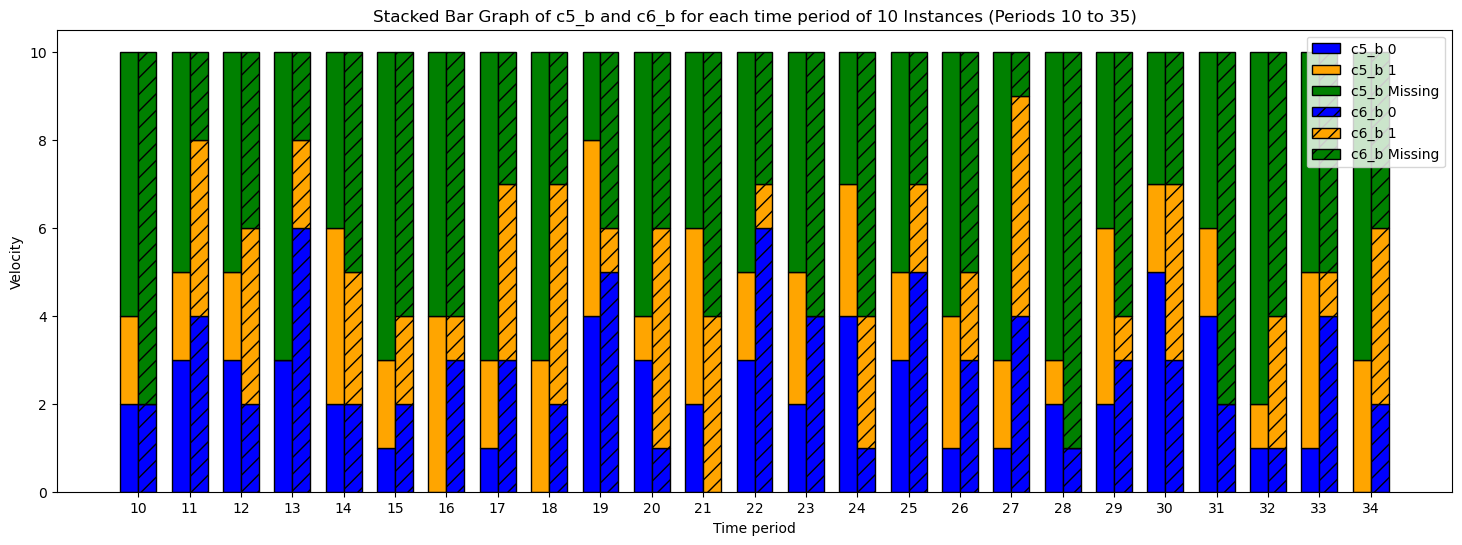

In [61]:
plot_grouped_stacked_bar_graph(
    X_df_encoded_m, "c5_b", "c6_b", chunk_size=10, start_period=10, end_period=35
)